In [1]:
import pandas as pd
import imageio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import os

import tensorflow as tf
from tensorflow import keras

In [2]:
imgSize=128
densSize=64

In [3]:
from scatter_utils import *
from scatter_augmentations import *
from data_generator import *
from scatter_rec_model import *
from physics_loss import *

# Create and compile the neural network

In [4]:
model = res2D3D(64, dropRate=0.2)
model.compile(loss=physicsLoss, optimizer=keras.optimizers.Adam(), metrics=['acc'])

# Dataset

Read the example datasets and create generators for both training and validation

The complete dataset consist of 140k image pairs, split at a ratio of 0.2 into training and validation set. The example sets contain the first 1000 data pairs for the training set and the last 100 pairs for the validation set.

In [5]:
datapath = './datasets/main/'
train_df = pd.read_csv(datapath + 'infos1.csv', index_col = 'nr',usecols=range(5)).reset_index()
val_df = pd.read_csv(datapath + 'infos14.csv', index_col = 'nr',usecols=range(5)).reset_index()

Define Generators of the training and validation set. The batch_size of 8 is set to enable training on a single RTX 2080 ti GPU with 11GB von VRAM. The original training was performed with mirrored strategy on four GPUs in parallel, allowing for a batch size of 32.

In [6]:
batch_size = 8


train_generator = ScatterDensityGenerator(train_df.reset_index(), 
                                   path = datapath,
                                   x_col='scatter', 
                                   y_col='real', 
                                   batch_size=batch_size, 
                                   shuffle=True, 
                                   augment=True,
                                   x_size=(128,128),
                                   y_size=(64,64,64))

val_generator = ScatterDensityGenerator(val_df.reset_index(), 
                                 path = datapath,
                                 x_col='scatter', 
                                 y_col='real', 
                                 batch_size=batch_size, 
                                 shuffle=False, 
                                 augment=False,
                                 x_size=(128,128),
                                 y_size=(64,64,64))

found 1000 image pairs
found 100 image pairs


# Training

This branch of the code demonstartes the physics informed training of the neural network on an example portion of the training data set.

This step can be skipped for the evaluations in the next sections

In [7]:
epochs = 2

hist = model.fit(train_generator, 
                 epochs=epochs, 
                 validation_data=val_generator,
                 verbose=1, 
                 workers=12)

Epoch 1/2
125/125 [==============================] - 148s 1s/step - loss: 0.0102 - acc: 0.6154 - val_loss: 0.0134 - val_acc: 0.2584
Epoch 2/2
125/125 [==============================] - 148s 1s/step - loss: 0.0082 - acc: 0.6966 - val_loss: 0.0137 - val_acc: 0.4979


# Testing

## Load weights of fully trained network used throughout publication

In [8]:
model.load_weights('cluster2Dto3Dweights.h5')

## Validation set
Test the scatter reproduction between input images and neural network predictions

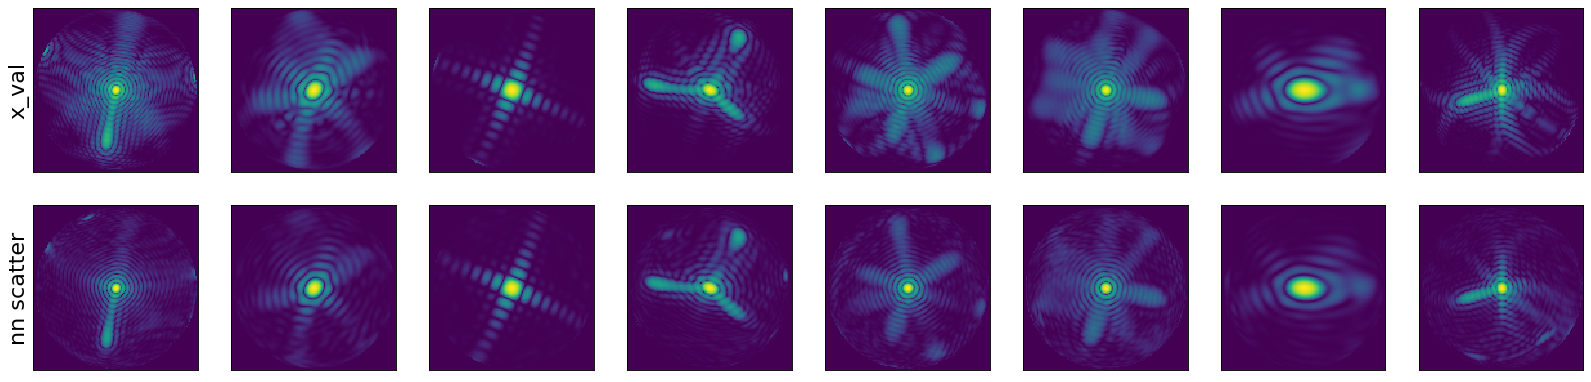

In [10]:
x_val, y_val = val_generator.batch_gen(0)
p_val = model.predict(x_val)

fig, axes = plt.subplots(nrows=2, ncols=8, figsize=(25, 6), dpi= 80, facecolor='w', edgecolor='k')

rows=['x_val','nn scatter']
for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, rotation=90, size=20)

for ind in range(np.min([8, len(x_val)])):
    axes[0,ind].imshow(x_val[ind].squeeze())
    axes[1,ind].imshow(np.log(np.abs(scatterSim(np.round(p_val[ind])))**2+10**3))
    

for ax in axes.flat:
    ax.set_xticks(ticks=[])
    ax.set_yticks(ticks=[])
    
plt.show()

## Test set performance

Cerate a data generator for the test set sampled from the same base solids as test and validation set, but cropped along random symmetry axes.

In [11]:
testpath = './datasets/test/'
testfile = pd.read_csv(testpath + 'infos1.csv', index_col = 'nr',usecols=range(5)).reset_index()

test_generator = ScatterDensityGenerator(testfile.reset_index(), 
                                 path = testpath,
                                 x_col='scatter', 
                                 y_col='real', 
                                 batch_size=8, 
                                 shuffle=False, 
                                 augment=False,
                                 x_size=(128,128),
                                 y_size=(64,64,64))

found 1000 image pairs


Visualize the neural network predictions on batches of 8 of the test set. Setting "batch_num" allows the selection of the batch.

The pairs of scattering pattern (x_test) and ground truth object (y_test) are displayed in tge top rows. The third row shows the object prediction by the neural network and the bottom row contains the corresponding simulated scattering patterns. The threee dimensional object densisties are compressed into two dimensions by calculating the distance of the object surface to the tensor boundray in negative z-direction. This can be understood as a depth map when looking at the object in direction of the incoming beam.

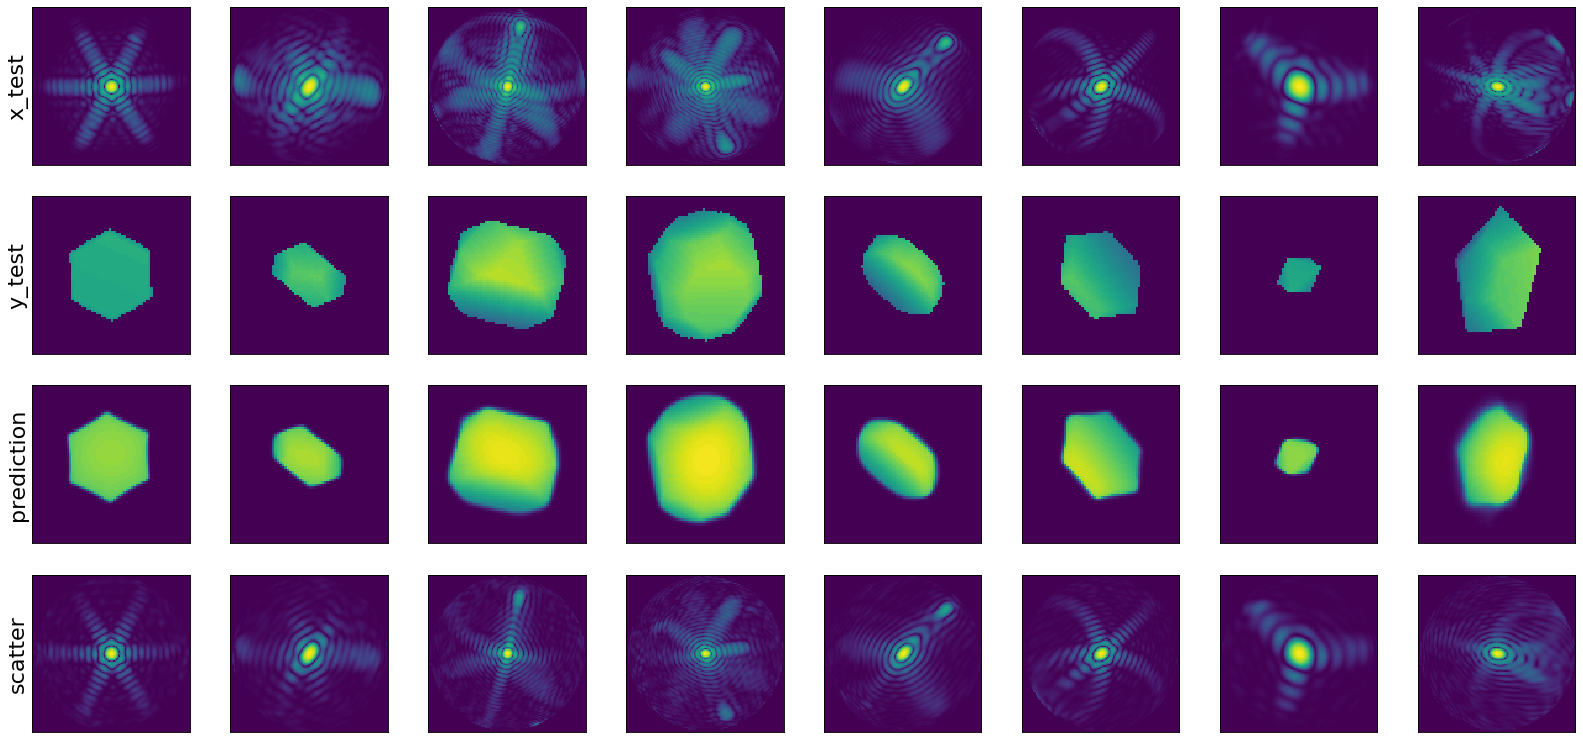

In [12]:
batch_num = 0
x_test, y_test = test_generator.batch_gen(batch_num)
p_test = model.predict(x_test)


fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(25, 12), dpi= 80, facecolor='w', edgecolor='k')

rows=['x_test','y_test','prediction','scatter']
for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, rotation=90, size=20)

for ind in range(np.min([8, len(x_test)])):
    axes[0,ind].imshow(x_test[ind].squeeze())
    axes[1,ind].imshow(depth_from_dens(y_test[ind]).squeeze(),norm=colors.Normalize(vmin=0.,vmax=1.0))
    axes[2,ind].imshow(depth_from_dens(p_test[ind]).squeeze(),norm=colors.Normalize(vmin=0.,vmax=1.0))
    axes[3,ind].imshow(np.log(np.abs(scatterSim(np.round(p_test[ind])))**2+10**3))
    

for ax in axes.flat:
    ax.set_xticks(ticks=[])
    ax.set_yticks(ticks=[])
    
plt.show()

## Experiment

In [18]:
exp_path = './datasets/exp/'
expInfos = pd.read_csv(exp_path + 'expLabels.csv', index_col = 'nr')
X_exp = np.array([imageio.imread(exp_path + impaths)[:,:].reshape(imgSize,imgSize,1)/(255) for impaths in expInfos.scatter])

#compensate the non-linear scaling of the original colormap
expScaling = lambda x: np.piecewise(x, 
                                    [x <= 0, 0 < x <= 0.3, 0.3 < x <= 0.88, 0.88 < x < 1, x >= 1], 
                                    [0, lambda val: 0.38 / 0.3 * val, lambda val: 0.25 / 0.4 * (val - 0.3) + 0.38, lambda val: (1 - 0.7425) / (1 - 0.88) * (val -0.88) + 0.7425, 1])
expScaler = np.vectorize(expScaling)
X_exp = expScaler(X_exp)

In [19]:
Y_exp = model.predict(X_exp)

Display neural network predictions from the experimental input images (top row). The precitions are shown as depth maps in beam direction (central row). The corresponding simulated scattering patterns can be found in the bottom row.

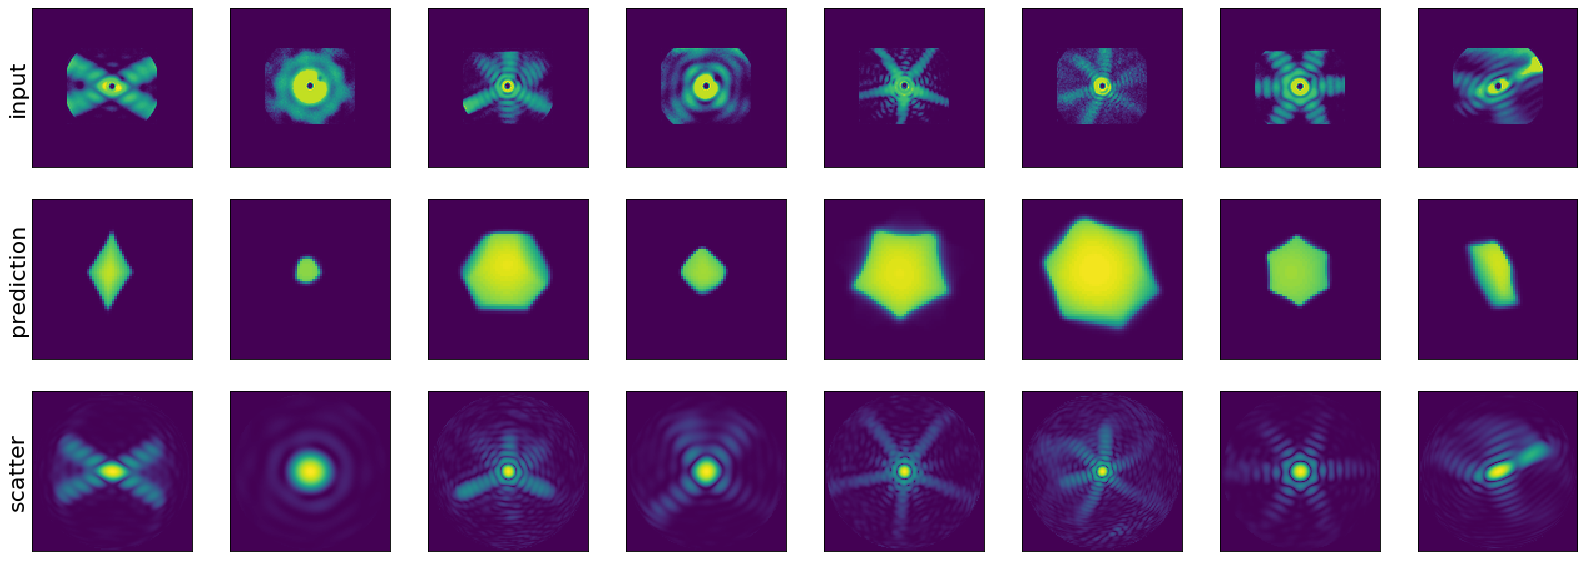

In [20]:
fig, axes = plt.subplots(nrows=3, ncols=8, figsize=(25, 9), dpi= 80, facecolor='w', edgecolor='k')

rows=['input','prediction','scatter']
for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, rotation=90, size=20)


for ind in range(len(X_exp)):
    axes[0,ind].imshow(X_exp[ind].squeeze())
    axes[1,ind].imshow(depth_from_dens(Y_exp[ind]).squeeze(),norm=colors.Normalize(vmin=0.,vmax=1.0))
    axes[2,ind].imshow(np.log(np.abs(scatterSim(np.round(Y_exp[ind])))**2+10**3))

    
for ax in axes.flat:
    ax.set_xticks(ticks=[])
    ax.set_yticks(ticks=[])

    
plt.show()

Investigate a single experiment prediction by displaying all 64 slices in z-direction of the density tensor.

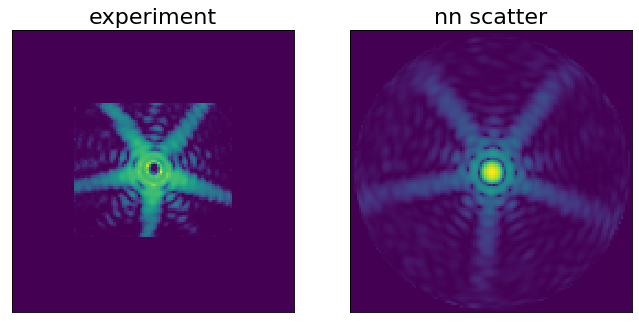

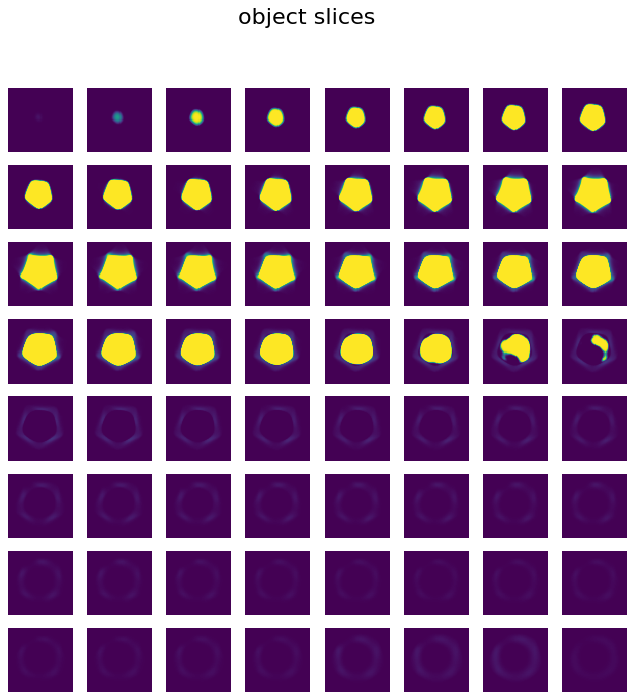

In [33]:
expInd = 4

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')

axes[0].imshow(X_exp[expInd].reshape(128,128))
axes[0].set_title('experiment', size=20)
axes[1].imshow(np.log(np.abs(scatterSim(np.round(Y_exp[expInd])))**2+10**3))
axes[1].set_title('nn scatter', size=20)

for ax in axes.flat:
    ax.set_xticks(ticks=[])
    ax.set_yticks(ticks=[])
plt.show()


fig = plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
for ind in range(Y_exp[expInd].shape[0]):
    plt.subplot(8,8,ind + 1)
    plt.imshow(Y_exp[expInd][ind].reshape(64,64),norm=colors.Normalize(vmin=0.,vmax=1.0))
    plt.axis('off')
fig.suptitle('object slices', size=20)
plt.show()